In [1]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/archive.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/archive.zip
replace leapGestRecog/00/01_palm/frame_00_01_0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [39]:
import os

import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2
from facenet_pytorch import MTCNN

In [5]:
def get_data(directory):
    data = pd.DataFrame()
    basedir = directory
    for man in os.listdir(basedir):
        for sign in os.listdir(basedir+man+'/'):
            for location in os.listdir(basedir+man+'/'+sign+'/'):
                data = data.append({'Location': basedir+man+'/'+sign+'/'+location, 'Sign':sign},ignore_index=True)
    return data

In [6]:
data = get_data('leapgestrecog/leapGestRecog/')
data

,Location,Sign
0,leapgestrecog/leapGestRecog/03/07_ok/frame_03_...,07_ok
1,leapgestrecog/leapGestRecog/03/07_ok/frame_03_...,07_ok
2,leapgestrecog/leapGestRecog/03/07_ok/frame_03_...,07_ok
3,leapgestrecog/leapGestRecog/03/07_ok/frame_03_...,07_ok
4,leapgestrecog/leapGestRecog/03/07_ok/frame_03_...,07_ok
...,...,...
19995,leapgestrecog/leapGestRecog/04/08_palm_moved/f...,08_palm_moved
19996,leapgestrecog/leapGestRecog/04/08_palm_moved/f...,08_palm_moved
19997,leapgestrecog/leapGestRecog/04/08_palm_moved/f...,08_palm_moved
19998,leapgestrecog/leapGestRecog/04/08_palm_moved/f...,08_palm_moved


In [7]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=13)
print(f'Тренировочный набор: {data_train.shape}')
print(f'Тестовый набор: {data_test.shape}')

Тренировочный набор: (15000, 2)
Тестовый набор: (5000, 2)


In [8]:
data_train.head()

,Location,Sign
2511,leapgestrecog/leapGestRecog/08/10_down/frame_0...,10_down
14501,leapgestrecog/leapGestRecog/09/10_down/frame_0...,10_down
11955,leapgestrecog/leapGestRecog/01/08_palm_moved/f...,08_palm_moved
11205,leapgestrecog/leapGestRecog/01/09_c/frame_01_0...,09_c
8229,leapgestrecog/leapGestRecog/02/06_index/frame_...,06_index


In [9]:
data_test.head()

,Location,Sign
10138,leapgestrecog/leapGestRecog/01/07_ok/frame_01_...,07_ok
15088,leapgestrecog/leapGestRecog/09/03_fist/frame_0...,03_fist
19626,leapgestrecog/leapGestRecog/04/01_palm/frame_0...,01_palm
1922,leapgestrecog/leapGestRecog/03/08_palm_moved/f...,08_palm_moved
989,leapgestrecog/leapGestRecog/03/02_l/frame_03_0...,02_l


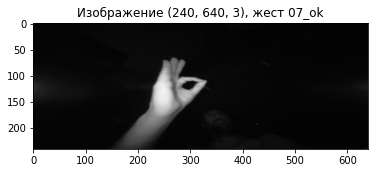

In [10]:
location = data_train['Location'][100]
sign = data_train['Sign'][100]
image = cv2.imread(location)
plt.imshow(image)
plt.title(f'Изображение {image.shape}, жест {sign}')
plt.show()

In [11]:
classes_train = data_train['Sign'].unique()
classes_test = data_test['Sign'].unique()
print(f'Train Classes - {classes_train}')
print(f'Test Classes - {classes_test}')

Train Classes - ['10_down' '08_palm_moved' '09_c' '06_index' '07_ok' '05_thumb' '03_fist'
 '04_fist_moved' '01_palm' '02_l']
Test Classes - ['07_ok' '03_fist' '01_palm' '08_palm_moved' '02_l' '04_fist_moved'
 '10_down' '05_thumb' '06_index' '09_c']


In [12]:
print(data_train['Sign'].value_counts())
print(data_test['Sign'].value_counts())

01_palm          1531
07_ok            1529
10_down          1521
02_l             1510
09_c             1509
04_fist_moved    1488
03_fist          1487
08_palm_moved    1483
05_thumb         1473
06_index         1469
Name: Sign, dtype: int64
06_index         531
05_thumb         527
08_palm_moved    517
03_fist          513
04_fist_moved    512
09_c             491
02_l             490
10_down          479
07_ok            471
01_palm          469
Name: Sign, dtype: int64


In [13]:
def sign_to_class(sign):
    if sign == '01_palm':
        return 0
    elif sign == '02_l':
        return 1
    elif sign == '03_fist':
        return 2
    elif sign == '04_fist_moved':
        return 3
    elif sign == '05_thumb':
        return 4
    elif sign == '06_index':
        return 5
    elif sign == '07_ok':
        return 6
    elif sign == '08_palm_moved':
        return 7
    elif sign == '09_c':
        return 8
    elif sign == '10_down':
        return 9
    
def digit_to_classname(digit):
    if digit == 0:
        return 'palm'
    elif digit == 1:
        return 'l'
    elif digit == 2:
        return 'fist'
    elif digit == 3:
        return 'fist_moved'
    elif digit == 4:
        return 'thumb'
    elif digit == 5:
        return 'index'
    elif digit == 6:
        return 'ok'
    elif digit == 7:
        return 'palm_moved'
    elif digit == 8:
        return 'c'
    elif digit == 9:
        return 'down'

In [14]:
train_tfms = tt.Compose([
                         tt.ToPILImage(),
                         tt.Grayscale(num_output_channels=1),
                         tt.Resize((48,48)),
                         tt.RandomHorizontalFlip(), 
                         tt.RandomRotation(30), 
                         tt.ToTensor()])

test_tfms =  tt.Compose([
                         tt.ToPILImage(),
                         tt.Grayscale(num_output_channels=1),
                         tt.Resize((48,48)),
                         tt.ToTensor()])

In [15]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.image_arr = self.data.iloc[:,0] # имена файлов картинок из датасета
        self.label_arr = self.data.iloc[:,1] # имена классов
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
        
    def __getitem__(self, index):
        # загружаем картинки
        img = cv2.imread(self.image_arr[index])
        if self.transform is not None:  #преобразование картинок
            img = self.transform(img)
        
        # загружаем классы
        sign = self.label_arr[index]
        sign_class = sign_to_class(sign) #переводим название класса в число

        return (img, sign_class)

In [16]:
#сбрасываем индексы
data_train.reset_index(drop=True,inplace=True)
data_test.reset_index(drop=True,inplace=True)

#создаем датасеты
train_data = CustomDataset(data_train, transform=train_tfms)
test_data = CustomDataset(data_test, transform=test_tfms)

#создаем даталодеры
train_data_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=256, shuffle=False)

In [17]:
for idx, batch in enumerate(train_data_loader):
    print(idx, 'Tensor_img: ', batch[0].shape)  
    print(idx, 'Sign_class: ', batch[1].shape)  
    break

0 Tensor_img:  torch.Size([256, 1, 48, 48])
0 Sign_class:  torch.Size([256])


torch.Size([1, 48, 48])
tensor(6) ok


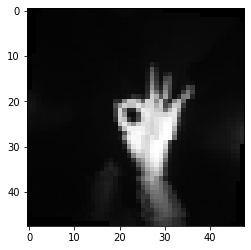

In [18]:
for img, label in train_data_loader:
    print(img[0].shape)
    print(label[0], digit_to_classname(label[0]))
    plt.imshow(img[0].permute(1, 2, 0)[:,:,0], cmap='gray')
    break

image: torch.Size([1, 48, 48])


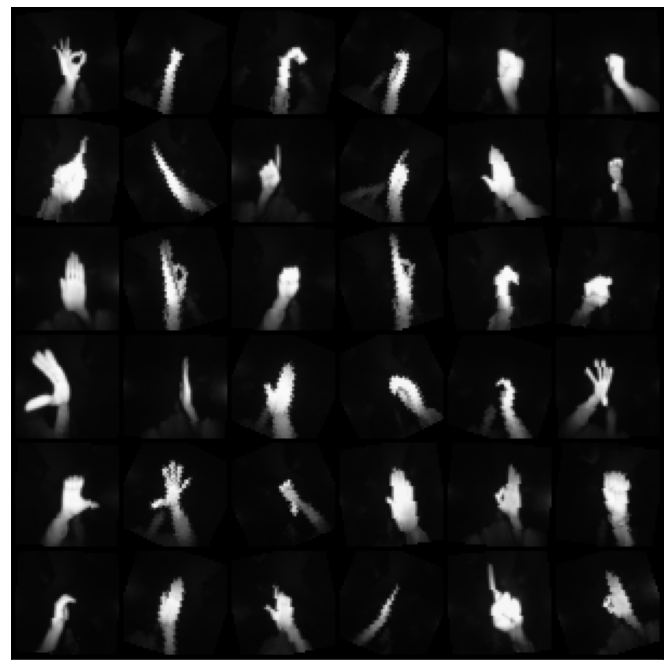

In [19]:
def show_batch(train_data_loader):
    for images, labels in train_data_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(f'image: {images[0].shape}')
        ax.imshow(make_grid(images[:36], nrow=6).permute(1, 2, 0))
        break

show_batch(train_data_loader)

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [21]:
# Class ResNet

def conv_block(in_channels, out_channels, pool=False):
    
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
        
    return nn.Sequential(*layers)

def linear_block(input_dim, output_dim, activation = False, dropout = 0.3):
    
    layers = [nn.Linear(input_dim, output_dim),
             nn.Dropout(dropout)]
    if activation:
        layers.append(nn.ReLU())
        
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [22]:
model = ResNet(1, 10).to(device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [28]:
%%time

epochs = 15
max_lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), max_lr)

epoch_losses = []

for epoch in range(epochs):
    
    running_loss = 0.0
    epoch_loss = []

    for batch_idx, (data, labels) in enumerate(train_data_loader):

        model.train()
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        
    test_running_loss = 0
    test_epoch_loss = []

    for batch_idx, (data, labels) in enumerate(test_data_loader):

        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
                
        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())
        
        
    print(f'Epoch {epoch+1}, train loss: {np.mean(epoch_loss)}, test loss: {np.mean(test_epoch_loss)}')
    epoch_losses.append(epoch_loss)

Epoch 1, train loss: 2.2375478178767834, test loss: 2.721593511104584
Epoch 2, train loss: 0.5118540853767072, test loss: 2.0648233532905578
Epoch 3, train loss: 0.24640837943149826, test loss: 3.18369140625
Epoch 4, train loss: 0.1283118832161871, test loss: 0.8398685395717621
Epoch 5, train loss: 0.07352053238299944, test loss: 0.1574126098304987
Epoch 6, train loss: 0.06850683951150563, test loss: 0.053791198041290046
Epoch 7, train loss: 0.0769054406338324, test loss: 2.2379490971565246
Epoch 8, train loss: 0.032669034889125724, test loss: 0.1512208167463541
Epoch 9, train loss: 0.01685754800515281, test loss: 0.06161794327199459
Epoch 10, train loss: 0.026271073711972872, test loss: 0.15768589451909065
Epoch 11, train loss: 0.026619237366179795, test loss: 0.31126435920596124
Epoch 12, train loss: 0.03972352056969273, test loss: 0.10153475888073445
Epoch 13, train loss: 0.028313426944127276, test loss: 0.07058346644043922
Epoch 14, train loss: 0.029348719825620873, test loss: 1.52

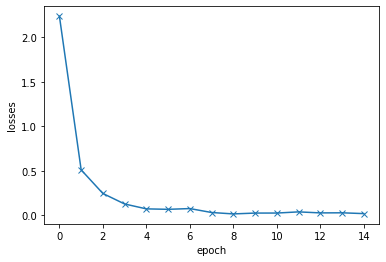

In [29]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

In [30]:
model_path = './gesture_classification_model.pth'
torch.save(model, model_path)

In [34]:
net = torch.load('./gesture_classification_model.pth')
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

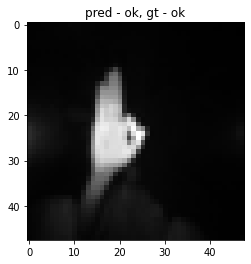

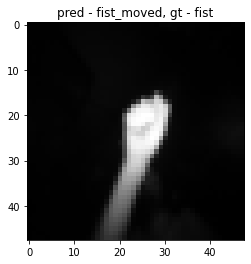

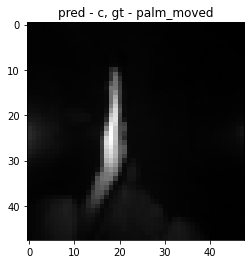

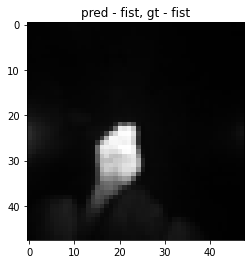

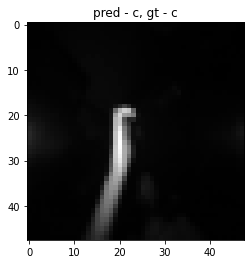

In [65]:
with torch.no_grad():
    for i, data in enumerate(test_data_loader, 3):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].squeeze().cpu(), cmap='gray')
        plt.show()
        if i>6:
            break

In [145]:
from google.colab import files
uploaded = files.upload()

Saving test_pic1.jpg to test_pic1 (3).jpg
Saving test_pic2.jpg to test_pic2.jpg
Saving test_pic3.jpg to test_pic3.jpg
Saving test_pic4.jpg to test_pic4.jpg
Saving test_pic5.jpg to test_pic5.jpg


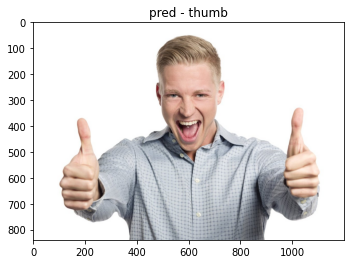

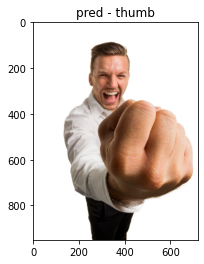

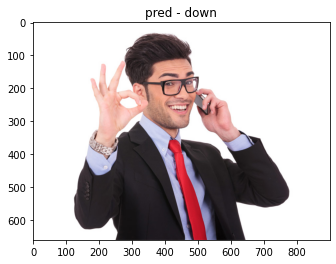

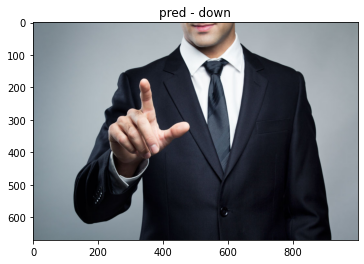

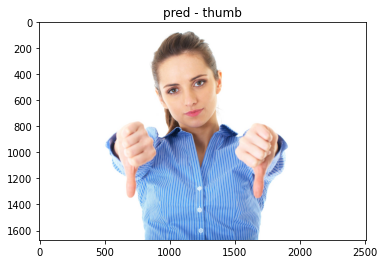

In [151]:
test_photo_1= 'test_pic1 (3).jpg'
test_photo_2 = 'test_pic2.jpg'
test_photo_3 = 'test_pic3.jpg'
test_photo_4 = 'test_pic4.jpg'
test_photo_5 = 'test_pic5.jpg'

for test_photo in [test_photo_1, test_photo_2, test_photo_3, test_photo_4, test_photo_5]:
    image = cv2.imread(test_photo)
    image_model = test_tfms(image).unsqueeze(1).to(device)
    output_model = net(image_model)
    plt.title(f'pred - {digit_to_classname(output_model[0].argmax())}')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [150]:
# Модель показывает относительно неплохие результаты на валидационных данных и средние на тестовых. Я использовал часть изображений, иногда попадает сразу на 100% , иногда вообще не угадывает